<a href="https://colab.research.google.com/github/MerCator1984/Moriarty1/blob/main/tesssssss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
train_data = '/content/drive/MyDrive/Data/Train'
test_data = '/content/drive/MyDrive/Data/Test'

In [87]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap',
                    validation_split = 0.4
                    )

train_generator = train_datagen.flow_from_directory(train_data,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 1384 images belonging to 3 classes.


In [88]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(test_data,
                                                            batch_size=16,
                                                            class_mode='categorical',
                                                            target_size=(150, 150))

Found 346 images belonging to 3 classes.


In [89]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 17, 17, 128)     

In [90]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [91]:
# callbacks
accuracy_threshold = 100e-2
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= accuracy_threshold:
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
            self.model.stop_training = True

In [92]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              callbacks = [my_callbacks()])

Epoch 1/30
44/44 [==============================] - 76s 2s/step - loss: 0.2075 - accuracy: 0.9003 - val_loss: 1.7432e-05 - val_accuracy: 1.0000
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 1.7579e-06 - accuracy: 1.0000
For Epoch 1 
Accuracy has reach = 100.00% training has been stopped.
44/44 [==============================] - 77s 2s/step - loss: 1.7579e-06 - accuracy: 1.0000 - val_loss: 8.8546e-08 - val_accuracy: 1.0000


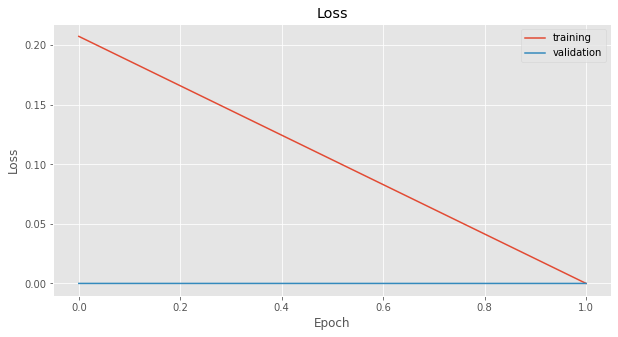

In [94]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 2), H.history["loss"], label="training")
plt.plot(np.arange(0, 2), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

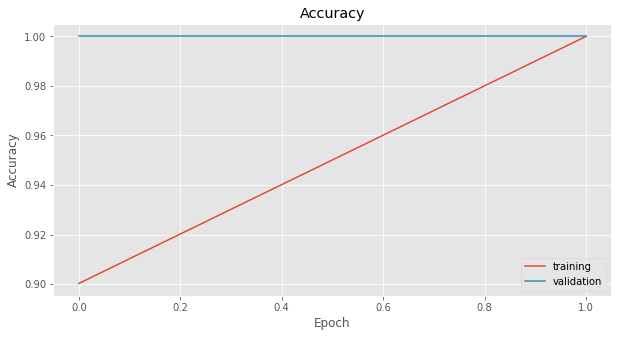

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 2), H.history["accuracy"], label="training")
plt.plot(np.arange(0, 2), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [110]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [108]:
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('fruit.tflite')
tflite_model_file.write_bytes(tflite_model)

27256772